<a href="https://colab.research.google.com/github/juelha/IANNWTF/blob/sabine/hw08_Sabine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# imports
import tensorflow as tf 
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
# dataset and preprosessing
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

for_TSNE = tf.data.Dataset.from_tensor_slices((x_test, y_test))

x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_test = tf.data.Dataset.from_tensor_slices(x_test)

def add_noise(images): 
  return tf.add(images, tf.random.normal((28,28,1), mean=0, stddev=1))

def preprocessing(tensor):
  tensor = tensor.map(lambda tensor: (tf.cast(tensor, tf.float32) / 255.)) # normalise
  tensor = tensor.map(lambda tensor: (tf.expand_dims(tensor, -1))) # make 3D in case
  tensor = tensor.map(lambda tensor: (add_noise(tensor), tensor)) # add noise with random 28,28 matrix 
  tensor = tensor.map(lambda images, target: (tf.clip_by_value(images, clip_value_min=0, clip_value_max=1), target)) # keep values normalised by clipping
  tensor = tensor.cache()
  tensor = tensor.shuffle(1000)
  tensor = tensor.batch(32)
  tensor = tensor.prefetch(20)
  return tensor

train_dataset = x_train.apply(preprocessing)
test_dataset = x_test.apply(preprocessing)

# for TSNE 

def preprocessing_TSNE(tensor): 
  tensor = tensor.map(lambda image, target: (tf.cast(image, tf.float32) / 255., target))
  tensor = tensor.map(lambda image, target: (tf.expand_dims(image, -1), target))
  tensor = tensor.cache()
  tensor = tensor.shuffle(1000)
  tensor = tensor.batch(32)
  tensor = tensor.prefetch(20)
  return tensor


for_TSNE = for_TSNE.apply(preprocessing_TSNE)


# for plotting
for image, target in test_dataset: 
  image_model = image
  image_noisy = image.numpy()
  print(image_model.shape, image_noisy.shape)
  break

print(train_dataset)
print(tf.data.experimental.cardinality(train_dataset), tf.data.experimental.cardinality(test_dataset))

11501568/11490434 [==============================] - 0s 0us/step
(32, 28, 28, 1) (32, 28, 28, 1)
<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.float32, tf.float32)>
tf.Tensor(1875, shape=(), dtype=int64) tf.Tensor(313, shape=(), dtype=int64)


#2.1 Convolutional Autoencoder

• The Autoencoder should consist of an encoder and a decoder, which can
be called independently. 6
• Encoder: The encoder should reduce the size of feature maps like a CNN.78
At the end of the encoder, flatten the feature maps and use a dense layer
to produce an embedding of a certain size. 9
• Decoder: The decoder takes the embedding from the encoder as input.
Use a dense layer to restore the dimensionality of the flattened feature
maps from the encoder and reshape the resulting vector into feature maps
again. Use upsampling or transposed convolutions to mirror your encoder.
As an output layer, use a convolutional layer with one filter and sigmoid
activation to produce an output image.


In [4]:
class Encoder(tf.keras.Model): 
  def __init__(self, latent_dim=10): 
    super(Encoder, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28))
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(7*7*64, activation='relu') # LOOK HERE JAY: Use a dense layer to force a tensor shape that in the encoder that can be reshaped in the decoder!
    self.dense2 = tf.keras.layers.Dense(latent_dim)

  @tf.function
  def call(self, input):
    x = self.conv1(input)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    return x

In [5]:
class Decoder(tf.keras.Model): 
  def __init__(self):
    super(Decoder, self).__init__()
    self.dense = tf.keras.layers.Dense(7*7*64, activation='relu')
    self.reshape = tf.keras.layers.Reshape((7,7,64))
    self.transconv = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(6,6), strides=(3,3), padding='valid', activation='relu') #valid padding means here zero padding which increases the size (opposite to a normal conv layer)
    self.out = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5,5), padding='valid', activation='relu')

  @tf.function
  def call(self, input): 
    x = self.dense(input)
    x = self.reshape(x)
    x = self.transconv(x)
    x = self.out(x)
    print(x.shape)
    return x


In [6]:
class Autoencoder(tf.keras.Model): 
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  @tf.function
  def call(self, input): 
    x = self.encoder(input)
    x = self.decoder(x)
    return x


In [7]:
def train_step(model, input, target, loss_function, optimizer):
  """Applys optimizer to all trainable variables of this model to
  minimize the loss (loss_function) between the target output and the
  predicted ouptut.
  :param input: tf.Tensor input to the model
  :param target: target output with repect to the input
  :return: the loss and the accuracy of the models prediction
   """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  """Calculate the mean loss and accuracy of the model over all elements
  of test_data.
  :param test_data: model is evaulated for test_data
  :param: loss_function: chosen cost function
  :return: mean loss and mean accuracy for all datapoints
  """

  # test over complete test data
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = tf.reduce_mean(test_loss_aggregator)
  #test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
  return test_loss

In [8]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = Autoencoder()
# Initialize the loss.
cross_entropy_loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []

#testing once before we begin
test_loss = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)

#check how model performs on train data once before we begin
train_loss = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} with train loss: {test_losses[-1]}')
    
    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)
    print(f'Train Losses: {train_loss}, Test Losses: {test_loss}')

(32, 28, 28, 1)
(32, 28, 28, 1)
(16, 28, 28, 1)
Epoch: 0 with train loss: 0.11380431801080704
Train Losses: 0.03199773281812668, Test Losses: 0.0347304567694664
Epoch: 1 with train loss: 0.0347304567694664
Train Losses: 0.026679761707782745, Test Losses: 0.03385114297270775
Epoch: 2 with train loss: 0.03385114297270775
Train Losses: 0.02311757206916809, Test Losses: 0.03487495705485344
Epoch: 3 with train loss: 0.03487495705485344
Train Losses: 0.023343268781900406, Test Losses: 0.03564021736383438
Epoch: 4 with train loss: 0.03564021736383438
Train Losses: 0.0176324974745512, Test Losses: 0.036275461316108704
Epoch: 5 with train loss: 0.036275461316108704
Train Losses: 0.014602860435843468, Test Losses: 0.03676699474453926
Epoch: 6 with train loss: 0.03676699474453926
Train Losses: 0.01219597365707159, Test Losses: 0.036981385201215744
Epoch: 7 with train loss: 0.036981385201215744
Train Losses: 0.016229722648859024, Test Losses: 0.03772934898734093
Epoch: 8 with train loss: 0.0377293

Noisy Image:


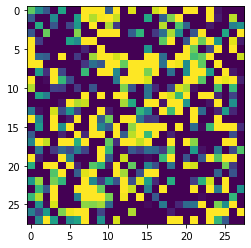

After Model:


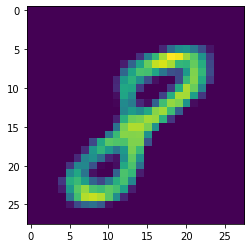

In [9]:
# Comparing Noisy and After Model Images

images = model(image_model)
images = images.numpy()

number = 8
print('Noisy Image:')
plt.imshow(np.squeeze(image_noisy[number]))
plt.show()
print('After Model:')
plt.imshow(np.squeeze(images[number]))
plt.show()

(1000,)
<class 'numpy.ndarray'>


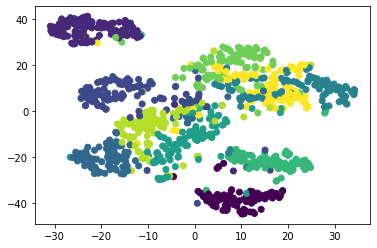

In [11]:
# Latent Space Analyisis 

test_1000 = for_TSNE.unbatch().take(1000).batch(1000)
encoder = model.encoder

for image, target in test_1000:
  #print(image.shape)
  output = encoder(image).numpy()
  targets = target.numpy()
  print(targets.shape)


embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(output)
print(type(embedded))

scatter = plt.scatter(x=embedded[:,0],y=embedded[:,1], c=targets)
#plt.legend(handles=scatter.legend_elements()[0], labels=targets)

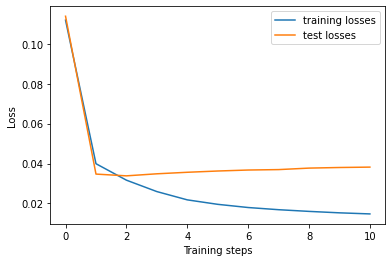

In [12]:
# Visualise loss for training and test data.

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training losses","test losses"))
plt.show()